In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
data = pd.read_csv('data/round_train.csv')

In [79]:
data = data[data.Tournament_Year.isin([2003])]

In [80]:
data.shape

(19393, 12)

In [81]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [83]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [84]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [85]:
rounds = data.groupby(['Tournament_Year','Tournament_#','Round_Number'])

In [86]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)

In [87]:
print n_players,n_rounds

665 186


In [88]:
def alpha(A,a):
    wq,vq=np.linalg.eig(A)
    return a/np.amax(np.absolute(wq))

In [95]:
BETA = .9
bins = 20
A = np.zeros((n_players*(n_rounds/bins+1),n_players*(n_rounds/bins+1)))
G = np.zeros((n_players*(n_rounds/bins+1),n_players*(n_rounds/bins+1)))
for round_ind,df in enumerate(rounds):
    df = df[1]
    round_group = round_ind/bins
    if round_ind>=80:
        continue
    a = .8
    for player_ind,player in enumerate(pd.unique(df.Player_Index)):
        arr = np.zeros(n_players)
        arr1 = np.zeros(n_players)
        arr[pd.unique(df.Player_Index)] = df.Round_Score.values / df[df.Player_Index==player].Round_Score.values.astype(float)
        arr[pd.unique(df.Player_Index)[player_ind]] = 0
        arr1[pd.unique(df.Player_Index)] = 1
        arr1[pd.unique(df.Player_Index)[player_ind]] = 0
        A[player + n_players*round_group,n_players*round_group:n_players*(round_group+1)] += arr
        G[player + n_players*round_group,n_players*round_group:n_players*(round_group+1)] += arr1
        for round_ind2,df2 in enumerate(rounds):
            round_group2 = round_ind2/bins
            if round_group==round_group2:
                continue
            else:
                A[player + n_players*round_group2,n_players*round_group:n_players*(round_group+1)] += BETA**(abs(round_group-round_group2)) * arr
                G[player + n_players*round_group2,n_players*round_group:n_players*(round_group+1)] += BETA**(abs(round_group-round_group2)) * arr1
w_a = (np.linalg.inv(np.eye(n_players*(n_rounds/bins+1)) - alpha(A,a)*A) * np.matrix(A).sum(1)).sum(1)
w_g = (np.linalg.inv(np.eye(n_players*(n_rounds/bins+1)) - alpha(G,a)*G) * np.matrix(G).sum(1)).sum(1)

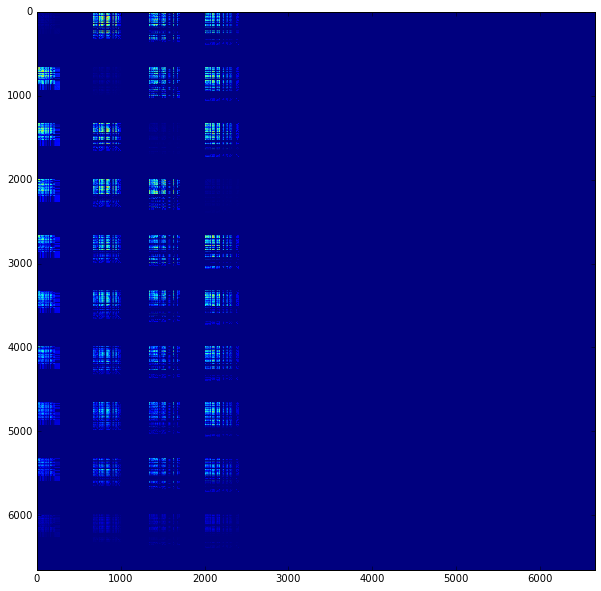

In [96]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A);

In [106]:
ranks = np.squeeze(np.asarray(w_a/w_g))

In [127]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [135]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[n_players*2:n_players*3]}).sort_values('rank',ascending=False)

,player_ind,player_name,rank
277,277,"Woods, Tiger",1.053067
12,12,"Els, Ernie",1.044260
180,180,"Weir, Mike",1.043307
27,27,"Goosen, Retief",1.040787
13,13,"Singh, Vijay",1.038518
5,5,"Price, Nick",1.033873
21,21,"Furyk, Jim",1.033663
198,198,"Love III, Davis",1.033565
296,296,"Fasth, Niclas",1.031549
43,43,"Couples, Fred",1.030096
